# 机器学习 实验3

**基于全链接网络的手写数字体识别**

- 数据：MNIST data set
- 本题目考察如何设计并实现一个简单的图像分类器，设置本题目的目的如下：
1. 理解基本的图像识别流程的方法（预处理、训练、预测等阶段）
2. 实现一个全连接神经网络分类器
3. 理解不同的分类器之间的区别，以及使用不同的更新方法优化神经网络

- 课后作业：
1. 完成测试集上的测试过程

- 附加题： 
1. 尝试使用不同的损失函数和正则化方法，观察并分析其对实验结果的影响 
2. 尝试使用不同的优化算法，观察并分析其对训练过程和实验结果的影响， (如batch GD, online GD, mini-batch GD, SGD, 或其它的优化算法，如Momentum, Adsgrad, Adam, Admax)
3. 增加训练的epoch，并绘制loss变化的图像
4. 更改网络的结构，查看对训练过程额和最终结果有何影响

- 补充：MINST是一个手写数字数据集，包括了若干手写数字体及其对应的数字，共60000个训练样本，10000个测试样本。每个手写数字被表示为一个28*28的向量。  

## 1 准备数据+数据预处理

In [38]:
import torch
from torchvision import transforms
from torchvision.datasets import mnist  # 导入内置的 mnist 数据

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),   # 将图像转换为PyTorch的张量（tensor）格式，这是神经网络模型所需的数据格式
    transforms.Normalize([0.5], [0.5])   # 如果不缩放，像素值范围较大可能会导致梯度爆炸或梯度消失等问题，从而影响模型的训练效果
])

# 使用mnist.MNIST()函数创建训练集、测试集两个数据集对象
train_set = mnist.MNIST('./data copy', train=True, transform=transform, download=True)
test_set = mnist.MNIST('./data copy', train=False, transform=transform, download=True)

cuda


### 1.1 了解数据

In [39]:
a_data, a_label = train_set[0]
a_data.shape

torch.Size([1, 28, 28])

### 1.2 创建数据加载器（DataLoader）对象

用于在训练和测试神经网络模型时加载数据

In [40]:
from torch.utils.data import*

train_data = DataLoader(train_set, batch_size=64,shuffle=True)
test_data = DataLoader(test_set, batch_size=128,shuffle=False)


## 2 neural network structure

In [41]:
from torch import nn

class FNN(nn.Module):
    def __init__(self):
        super(FNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784,400),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(400,200),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200,100),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(100,10))

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        output = self.layer4(x)
        return output

## 3 训练网络model

In [42]:
net = FNN().to(device)
net.parameters

<bound method Module.parameters of FNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)>

In [43]:
def train_model(net, train_data, test_data, loss_func, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0

        # Training process
        for image, label in train_data:
            image = image.to(device)
            label = label.to(device)
            image = image.view(image.size(0), -1)

            out = net(image)
            loss = loss_func(out, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        avg_loss = train_loss / len(train_data)
        train_accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)

        print(f'epoch:{epoch + 1}, Train loss：{avg_loss:.6f}, Train Accuracy: {train_accuracy:.6f}')

    # Testing process
    net.eval() 	# 将模型改为预测模式,不启用 BatchNormalization 和 Dropout
    correct = 0
    total = 0
    for image, label in test_data:
        image = image.to(device)
        label = label.to(device)
        image = image.view(image.size(0), -1)

        out = net(image)
        loss = loss_func(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.6f}')

    return train_losses, train_accuracies, test_accuracy

In [44]:
import torch
loss_cross = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=1e-3,lr=1e-3)


In [45]:
losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)


epoch:1, Train loss：2.284044, Train Accuracy: 0.150983
epoch:2, Train loss：2.225942, Train Accuracy: 0.303150
epoch:3, Train loss：2.103441, Train Accuracy: 0.469483
epoch:4, Train loss：1.811349, Train Accuracy: 0.534650
epoch:5, Train loss：1.363250, Train Accuracy: 0.636617
epoch:6, Train loss：1.018960, Train Accuracy: 0.726050
epoch:7, Train loss：0.822639, Train Accuracy: 0.776000
epoch:8, Train loss：0.699786, Train Accuracy: 0.809133
epoch:9, Train loss：0.615161, Train Accuracy: 0.831000
epoch:10, Train loss：0.555091, Train Accuracy: 0.847017
Test Accuracy: 0.859900


## 4 尝试不同正则化、优化方法，并分析结果

- 使用SGD随机梯度下降算法，尝试不同的L2正则化的参数lambda
- 使用adam优化算法，正则化参数

In [46]:
# 使用交叉熵损失函数，适用于多类分类问题


# SGD随机梯度下降


# Adam优化


### 4.1 使用SGD随机梯度下降，修改L2正则化参数

In [47]:
loss_cross = nn.CrossEntropyLoss()
# 将正则化参数从0.001改为0.01
optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=0.01,lr=1e-3)
net = FNN().to(device)

SGD_train_losses, SGD_train_accuracies, SGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

epoch:1, Train loss：2.306232, Train Accuracy: 0.106833
epoch:2, Train loss：2.306228, Train Accuracy: 0.106833
epoch:3, Train loss：2.306216, Train Accuracy: 0.106833
epoch:4, Train loss：2.306226, Train Accuracy: 0.106833
epoch:5, Train loss：2.306221, Train Accuracy: 0.106833
epoch:6, Train loss：2.306204, Train Accuracy: 0.106833
epoch:7, Train loss：2.306213, Train Accuracy: 0.106833
epoch:8, Train loss：2.306205, Train Accuracy: 0.106833
epoch:9, Train loss：2.306211, Train Accuracy: 0.106833
epoch:10, Train loss：2.306203, Train Accuracy: 0.106833
Test Accuracy: 0.105100


In [48]:
# 用不同优化算法、正则化参数训练


### 4.2 使用batch GD优化方式

In [49]:
import torch.nn as nn
import torch.optim as optim

train_data = DataLoader(train_set, batch_size=len(train_data),shuffle=True)

net = FNN().to(device)

loss_func = nn.CrossEntropyLoss()
optimizer_batchgd = optim.SGD(net.parameters(),weight_decay=1e-3, lr=0.001)

batchGD_train_losses, batchGD_train_accuracies, batchGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

epoch:1, Train loss：2.313288, Train Accuracy: 0.099283
epoch:2, Train loss：2.313286, Train Accuracy: 0.099283
epoch:3, Train loss：2.313287, Train Accuracy: 0.099283
epoch:4, Train loss：2.313288, Train Accuracy: 0.099283
epoch:5, Train loss：2.313286, Train Accuracy: 0.099283
epoch:6, Train loss：2.313287, Train Accuracy: 0.099283
epoch:7, Train loss：2.313289, Train Accuracy: 0.099283
epoch:8, Train loss：2.313289, Train Accuracy: 0.099283
epoch:9, Train loss：2.313291, Train Accuracy: 0.099283
epoch:10, Train loss：2.313286, Train Accuracy: 0.099283
Test Accuracy: 0.100300


### 4.3 使用online GD优化方式

In [50]:
# online GD可以理解为带mini-bach的SGD，batch_size=1
train_data = DataLoader(train_set, batch_size=1,shuffle=True)

net = FNN().to(device)

loss_func = nn.CrossEntropyLoss()
optimizer_onlinegd = optim.SGD(net.parameters(), weight_decay=1e-3, lr=0.001)

onlineGD_train_losses, onlineGD_train_accuracies, onlineGD_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_onlinegd, num_epochs=10)

epoch:1, Train loss：0.498560, Train Accuracy: 0.850550
epoch:2, Train loss：0.191420, Train Accuracy: 0.943000
epoch:3, Train loss：0.137301, Train Accuracy: 0.958167
epoch:4, Train loss：0.108672, Train Accuracy: 0.966800
epoch:5, Train loss：0.090728, Train Accuracy: 0.971883
epoch:6, Train loss：0.078878, Train Accuracy: 0.975717
epoch:7, Train loss：0.067857, Train Accuracy: 0.978817
epoch:8, Train loss：0.060650, Train Accuracy: 0.981667
epoch:9, Train loss：0.056376, Train Accuracy: 0.982733
epoch:10, Train loss：0.052139, Train Accuracy: 0.984150
Test Accuracy: 0.975000


### 4.4 使用mini-batch GD优化方式

In [51]:
train_data = DataLoader(train_set, batch_size=128,shuffle=True)
net = FNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer_minibatchgd = optim.SGD(net.parameters(),weight_decay=1e-3, lr=0.001)

minibatchGD_train_losses, minibatchGD_train_accuracies, minibatchGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_minibatchgd,num_epochs=10)

epoch:1, Train loss：2.293860, Train Accuracy: 0.132200
epoch:2, Train loss：2.276289, Train Accuracy: 0.155067
epoch:3, Train loss：2.254478, Train Accuracy: 0.196450
epoch:4, Train loss：2.224641, Train Accuracy: 0.249667
epoch:5, Train loss：2.181878, Train Accuracy: 0.308950
epoch:6, Train loss：2.116378, Train Accuracy: 0.375133
epoch:7, Train loss：2.015670, Train Accuracy: 0.439950
epoch:8, Train loss：1.866534, Train Accuracy: 0.509567
epoch:9, Train loss：1.666899, Train Accuracy: 0.573733
epoch:10, Train loss：1.444273, Train Accuracy: 0.631667
Test Accuracy: 0.671600


### 4.5 使用adam优化方式

In [52]:
import torch.nn as nn
from torch.optim import Adam
train_data = DataLoader(train_set, batch_size=64,shuffle=True)
net = FNN().to(device)
# 定义损失函数
loss_func = nn.CrossEntropyLoss()

# 使用Adam优化器
optimizer = Adam(net.parameters(), lr=0.001)

# 定义训练的epoch数量
num_epochs = 10

# 调用之前定义的训练函数
adam_train_losses, adam_train_accuracies, adam_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer, num_epochs)

epoch:1, Train loss：0.335153, Train Accuracy: 0.897067
epoch:2, Train loss：0.147523, Train Accuracy: 0.955033
epoch:3, Train loss：0.110134, Train Accuracy: 0.965883
epoch:4, Train loss：0.092205, Train Accuracy: 0.970983
epoch:5, Train loss：0.077515, Train Accuracy: 0.975150
epoch:6, Train loss：0.067704, Train Accuracy: 0.978000
epoch:7, Train loss：0.061430, Train Accuracy: 0.980117
epoch:8, Train loss：0.054774, Train Accuracy: 0.982333
epoch:9, Train loss：0.049356, Train Accuracy: 0.983217
epoch:10, Train loss：0.046309, Train Accuracy: 0.984500
Test Accuracy: 0.976700


### 4.6 使用Momentum优化算法

In [53]:
import torch.nn as nn
from torch.optim import SGD

net = FNN().to(device)
loss_func = nn.CrossEntropyLoss()

# Use Momentum optimizer
optimizer_momentum = SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 10

# Call the train_model function with the Momentum optimizer
momentum_train_losses, momentum_train_accuracies, momentum_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_momentum, num_epochs)

epoch:1, Train loss：1.419291, Train Accuracy: 0.584267
epoch:2, Train loss：0.420702, Train Accuracy: 0.878267
epoch:3, Train loss：0.334192, Train Accuracy: 0.901850
epoch:4, Train loss：0.290857, Train Accuracy: 0.914883
epoch:5, Train loss：0.259131, Train Accuracy: 0.923767
epoch:6, Train loss：0.228422, Train Accuracy: 0.933083
epoch:7, Train loss：0.203119, Train Accuracy: 0.940683
epoch:8, Train loss：0.180550, Train Accuracy: 0.946767
epoch:9, Train loss：0.161244, Train Accuracy: 0.952850
epoch:10, Train loss：0.145902, Train Accuracy: 0.957033
Test Accuracy: 0.957200


### 4.7 使用Adsgrad优化算法

In [54]:
# 使用adsgrad优化算法
net = FNN().to(device)
loss_func = nn.CrossEntropyLoss()

optimizer_adagrad = torch.optim.Adagrad(net.parameters(), lr=0.001)

num_epochs = 10

adagrad_train_losses, adagrad_train_accuracies, adagrad_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_adagrad, num_epochs)


epoch:1, Train loss：0.566203, Train Accuracy: 0.845550
epoch:2, Train loss：0.344089, Train Accuracy: 0.901433
epoch:3, Train loss：0.307324, Train Accuracy: 0.910900
epoch:4, Train loss：0.285066, Train Accuracy: 0.917617
epoch:5, Train loss：0.267643, Train Accuracy: 0.922600
epoch:6, Train loss：0.253719, Train Accuracy: 0.926650
epoch:7, Train loss：0.242245, Train Accuracy: 0.929933
epoch:8, Train loss：0.232477, Train Accuracy: 0.933017
epoch:9, Train loss：0.223596, Train Accuracy: 0.936083
epoch:10, Train loss：0.215756, Train Accuracy: 0.937883
Test Accuracy: 0.940600


### 4.8 使用Admax优化算法

In [55]:
from torch.optim import Adamax
net = FNN().to(device)
loss_func = nn.CrossEntropyLoss()

# 使用Adamax优化器
optimizer = Adamax(net.parameters(), lr=0.001)

num_epochs = 10

adamax_train_losses, adamax_train_accuracies, adamax_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer, num_epochs)


epoch:1, Train loss：0.423755, Train Accuracy: 0.873917
epoch:2, Train loss：0.202693, Train Accuracy: 0.938833
epoch:3, Train loss：0.141638, Train Accuracy: 0.957317
epoch:4, Train loss：0.109374, Train Accuracy: 0.967400
epoch:5, Train loss：0.088876, Train Accuracy: 0.972983
epoch:6, Train loss：0.072989, Train Accuracy: 0.977867
epoch:7, Train loss：0.061147, Train Accuracy: 0.981000
epoch:8, Train loss：0.053541, Train Accuracy: 0.983383
epoch:9, Train loss：0.045039, Train Accuracy: 0.986283
epoch:10, Train loss：0.039049, Train Accuracy: 0.987483
Test Accuracy: 0.978200


## 5 绘制不同optimizer的loss, accuracies图像和测试集的正确率

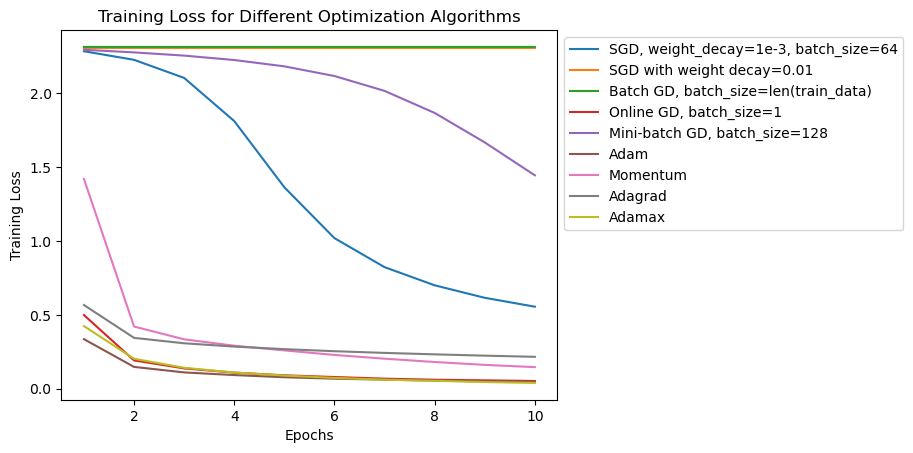

In [56]:
import matplotlib.pyplot as plt

# Define the x-axis values (epochs)
epochs = range(1, len(SGD_train_losses) + 1)

# Plot the training loss for each algorithm
plt.plot(epochs, losses_sgd, label='SGD, weight_decay=1e-3, batch_size=64')
plt.plot(epochs, SGD_train_losses, label='SGD with weight decay=0.01')
plt.plot(epochs, batchGD_train_losses, label='Batch GD, batch_size=len(train_data)')
plt.plot(epochs, onlineGD_train_losses, label='Online GD, batch_size=1')
plt.plot(epochs, minibatchGD_train_losses, label='Mini-batch GD, batch_size=128')
plt.plot(epochs, adam_train_losses, label='Adam')
plt.plot(epochs, momentum_train_losses, label='Momentum')
plt.plot(epochs, adagrad_train_losses, label='Adagrad')
plt.plot(epochs, adamax_train_losses, label='Adamax')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Optimization Algorithms')

# Show the legend
# 图例移到右边
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

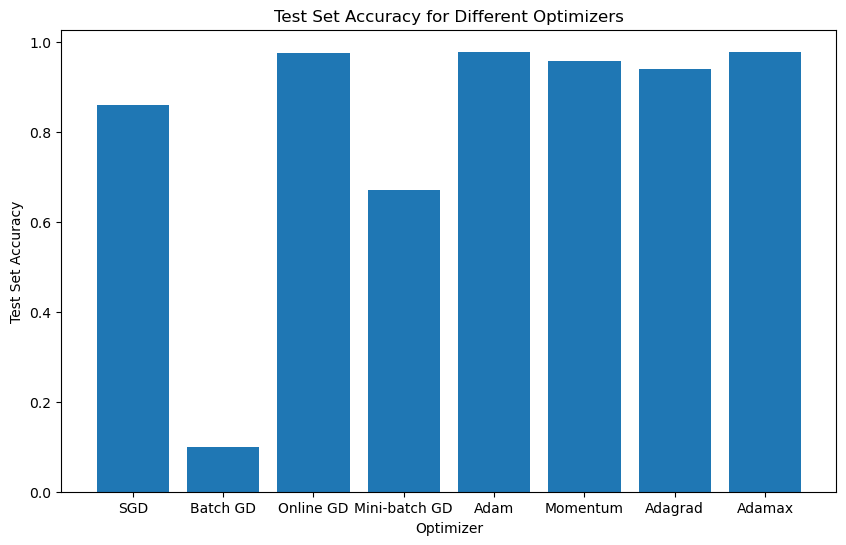

In [57]:
import matplotlib.pyplot as plt

# Define the optimizer names and test accuracies
optimizers = ['SGD', 'Batch GD', 'Online GD', 'Mini-batch GD', 'Adam', 'Momentum', 'Adagrad', 'Adamax']
test_accuracies = [test_ac_sgd, batchGD_test_accuracies, onlineGD_test_accuracies, minibatchGD_test_accuracies, adam_test_accuracies, momentum_test_accuracies, adagrad_test_accuracies, adamax_test_accuracies]

# Plot the bar graph
# 柱状图每个之间的距离开一些
plt.figure(figsize=(10, 6))
plt.bar(optimizers, test_accuracies)

# Add labels and title
plt.xlabel('Optimizer')
plt.ylabel('Test Set Accuracy')
plt.title('Test Set Accuracy for Different Optimizers')

# Display the plot
plt.show()

## 6 增加epoch并查看图像

epoch:1, Train loss：2.284654, Train Accuracy: 0.122300
epoch:2, Train loss：2.238600, Train Accuracy: 0.268467
epoch:3, Train loss：2.152212, Train Accuracy: 0.516450
epoch:4, Train loss：1.954169, Train Accuracy: 0.630533
epoch:5, Train loss：1.546422, Train Accuracy: 0.660367
epoch:6, Train loss：1.107016, Train Accuracy: 0.735483
epoch:7, Train loss：0.843780, Train Accuracy: 0.780900
epoch:8, Train loss：0.700791, Train Accuracy: 0.808900
epoch:9, Train loss：0.612679, Train Accuracy: 0.829267
epoch:10, Train loss：0.551271, Train Accuracy: 0.844683
Test Accuracy: 0.858200
epoch:1, Train loss：2.280659, Train Accuracy: 0.201667
epoch:2, Train loss：2.220441, Train Accuracy: 0.473983
epoch:3, Train loss：2.095221, Train Accuracy: 0.488667
epoch:4, Train loss：1.797741, Train Accuracy: 0.574283
epoch:5, Train loss：1.331150, Train Accuracy: 0.701900
epoch:6, Train loss：0.960506, Train Accuracy: 0.771217
epoch:7, Train loss：0.750991, Train Accuracy: 0.806483
epoch:8, Train loss：0.630099, Train Accu

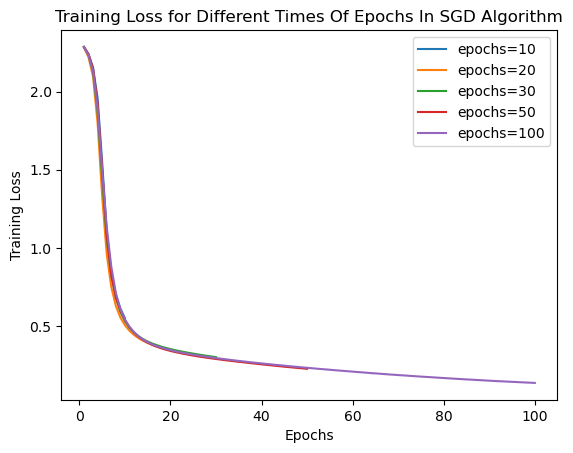

In [58]:
import numpy as np

epochs = [10, 20, 30, 50, 100]

for epoch in epochs:
    loss_cross = nn.CrossEntropyLoss()
    net = FNN().to(device)
    optimizer = torch.optim.SGD(net.parameters(),weight_decay=0, lr=1e-3)
    losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer,num_epochs=epoch)
    # Plot the training loss for each algorithm
    epochs_x = np.arange(1, epoch + 1)
    plt.plot(epochs_x, losses_sgd, label=f'epochs={epoch}')
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different Times Of Epochs In SGD Algorithm')

# Show the legend
plt.legend()

# Display the plot
plt.show()


## 7 更改网络结构并查看有什么影响

epoch:1, Train loss：2.283410, Train Accuracy: 0.216250
epoch:2, Train loss：2.229000, Train Accuracy: 0.303350
epoch:3, Train loss：2.124753, Train Accuracy: 0.385583
epoch:4, Train loss：1.895130, Train Accuracy: 0.539283
epoch:5, Train loss：1.485865, Train Accuracy: 0.659650
epoch:6, Train loss：1.111536, Train Accuracy: 0.733933
epoch:7, Train loss：0.870490, Train Accuracy: 0.776250
epoch:8, Train loss：0.721442, Train Accuracy: 0.803883
epoch:9, Train loss：0.628874, Train Accuracy: 0.823150
epoch:10, Train loss：0.567966, Train Accuracy: 0.837517
Test Accuracy: 0.850400
epoch:1, Train loss：2.287736, Train Accuracy: 0.171000
epoch:2, Train loss：2.216099, Train Accuracy: 0.357750
epoch:3, Train loss：2.065134, Train Accuracy: 0.439450
epoch:4, Train loss：1.796935, Train Accuracy: 0.553833
epoch:5, Train loss：1.547721, Train Accuracy: 0.589933
epoch:6, Train loss：1.389863, Train Accuracy: 0.613100
epoch:7, Train loss：1.295237, Train Accuracy: 0.623833
epoch:8, Train loss：1.231160, Train Accu

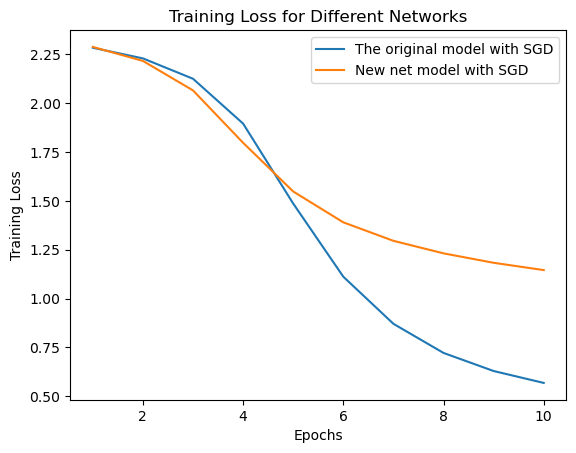

In [62]:
from torch import nn

class my_FNN(nn.Module):
    def __init__(self):
        super(my_FNN,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(784,400),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Linear(400,150),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(150,10),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        output = self.layer3(x)

        return output
    

net = FNN().to(device)
loss_cross = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=1e-3,lr=1e-3)
losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

my_net = my_FNN().to(device)
loss_cross = nn.CrossEntropyLoss()
my_optimizer_sgd = torch.optim.SGD(my_net.parameters(),weight_decay=1e-3,lr=1e-3)
my_losses_sgd, my_accs_sgd, my_test_ac_sgd = train_model(my_net,train_data,test_data,loss_cross,my_optimizer_sgd,num_epochs=10)

import matplotlib.pyplot as plt

# Define the x-axis values (epochs)
epochs = range(1, len(losses_sgd) + 1)
plt.plot(epochs, losses_sgd, label='The original model with SGD')
plt.plot(epochs, my_losses_sgd, label='New net model with SGD')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Networks')

plt.legend()

# Display the plot
plt.show()


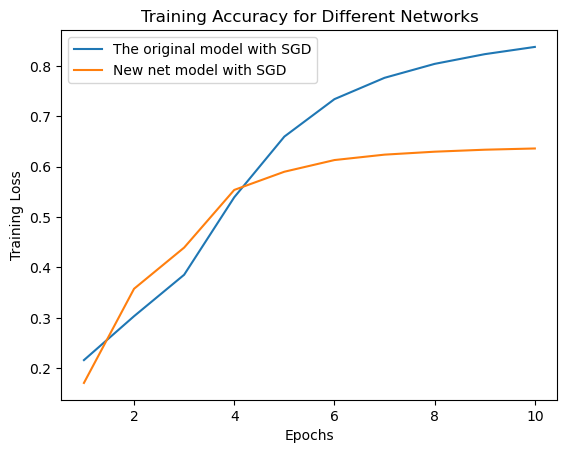

In [63]:

# Define the x-axis values (epochs)
epochs = range(1, len(accs_sgd) + 1)
plt.plot(epochs, accs_sgd, label='The original model with SGD')
plt.plot(epochs, my_accs_sgd, label='New net model with SGD')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Accuracy for Different Networks')

plt.legend()

# Display the plot
plt.show()

## 5 测试集上的准确率

同学们将测试过程补充在这里

In [61]:
# eval_loss = 0
# eval_acc = 0
# net.eval() 	# 将模型改为预测模式,不启用 BatchNormalization 和 Dropout

# for image, label in test_data:
#     image = image.view(image.size(0), -1)

#     # 进行测试
#     '''
#     步骤：
#     1. 前向传播计算loss
#     2. 计算测试集上的总eval_loss
#     3. 得到预测结果
#     4. 计算预测正确的图片数量
#     5. 得到elva_acc准确率
#     '''
    
    
    
    

# print('Eval Loss: {:.6f}, Eval Acc: {:.6f}'.format(eval_loss/len(test_data), eval_acc/len(test_data)))